- https://medium.com/@vanillaxiangshuyang/self-supervised-learning-on-tabular-data-with-tabnet-544b3ec85cee
- https://colab.research.google.com/drive/1P8Obe07DP3VeOld08ThyT1HnChLip_LO#scrollTo=gvy9vUUNOP0W

- https://www.kaggle.com/code/sisharaneranjana/semi-supervised-pre-training-with-tabnet#%F0%9F%94%8FDescription-of-the-dataset-
- https://dacon.io/en/codeshare/3837

In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

In [2]:
with open("./dataset/creditcard.pkl","rb") as file:
    data = pickle.load(file)

In [3]:
df = data.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 데이터 전처리

In [4]:
df = data.copy()

# Time 을 일중 시간으로 변환
df.loc[:, "Time"] = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24)

# Amount column 은 편차가 크므로 log-scale 로 변환
df['Amount'] = np.log(df.pop('Amount') + 0.001)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


# train_test_split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
features = df.values
labels = np.array(df.pop('Class'))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=0, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("===============")
print("X validation shape: ", X_val.shape)
print("y validation shape: ", y_val.shape)
print("===============")
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (71201, 31)
Y train shape:  (71201,)
X validation shape:  (71202, 31)
y validation shape:  (71202,)
X test shape:  (142404, 31)
Y test shape:  (142404,)


In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val= sc.transform(X_val)

# Network parameters

- https://github.com/dreamquark-ai/tabnet
- https://github.com/dreamquark-ai/tabnet/blob/develop/pretraining_example.ipynb

In [1]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

In [10]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
#     cat_idxs=cat_idxs,
#     cat_dims=cat_dims,
#     cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
    momentum = 0.9
)

# Self Supervised Training

In [11]:
max_epochs = 100

In [12]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 1.5683  | val_0_unsup_loss_numpy: 1.1571600437164307|  0:00:07s
epoch 5  | loss: 0.96061 | val_0_unsup_loss_numpy: 0.9526200294494629|  0:00:36s
epoch 10 | loss: 0.94933 | val_0_unsup_loss_numpy: 1.0185999870300293|  0:01:04s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.9526200294494629


In [13]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_val)
assert(reconstructed_X.shape==embedded_X.shape)

In [14]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_val)

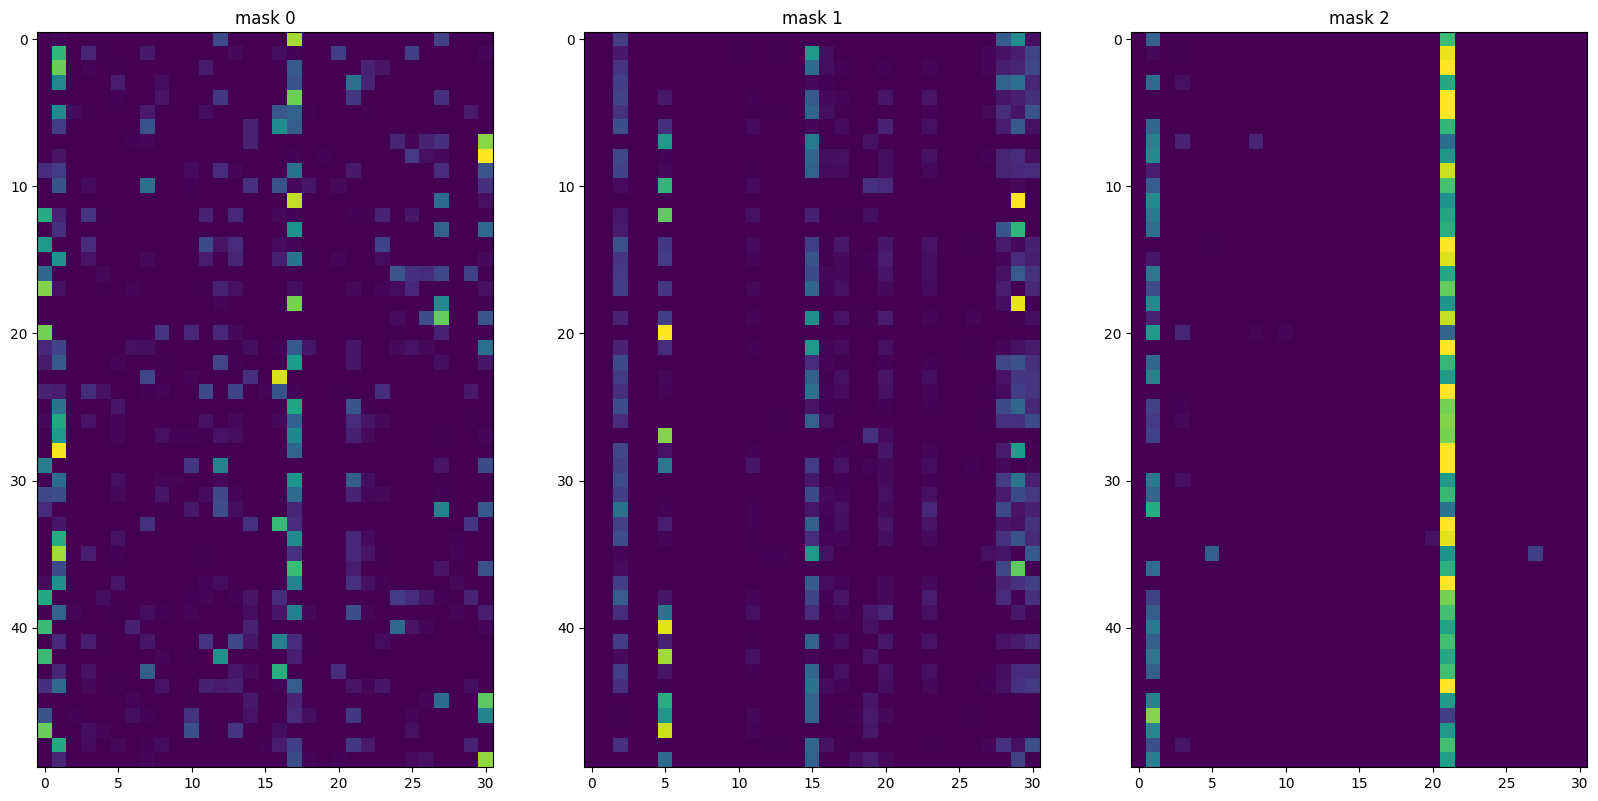

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Save and load the same way as other TabNet models

In [16]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


# Training

In [17]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                       momentum = 0.9
                      )

In [18]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score

class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score

In [19]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','f1'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

epoch 0  | loss: 0.34858 | train_logloss: 0.32642 | train_f1: 0.02462 | valid_logloss: 0.3311  | valid_f1: 0.02587 |  0:00:07s
epoch 5  | loss: 0.00513 | train_logloss: 0.00982 | train_f1: 0.59747 | valid_logloss: 0.01041 | valid_f1: 0.61244 |  0:00:44s
epoch 10 | loss: 0.00186 | train_logloss: 0.0015  | train_f1: 0.91829 | valid_logloss: 0.00258 | valid_f1: 0.89825 |  0:01:21s
epoch 15 | loss: 0.00138 | train_logloss: 0.00137 | train_f1: 0.92188 | valid_logloss: 0.0012  | valid_f1: 0.92419 |  0:02:01s
epoch 20 | loss: 0.00086 | train_logloss: 0.00296 | train_f1: 0.8839  | valid_logloss: 0.00523 | valid_f1: 0.85906 |  0:02:47s
epoch 25 | loss: 0.00089 | train_logloss: 0.00011 | train_f1: 0.98745 | valid_logloss: 0.0002  | valid_f1: 0.98462 |  0:03:25s
epoch 30 | loss: 0.00079 | train_logloss: 0.00014 | train_f1: 0.98745 | valid_logloss: 0.00032 | valid_f1: 0.98842 |  0:04:03s
epoch 35 | loss: 0.00066 | train_logloss: 0.00054 | train_f1: 0.94779 | valid_logloss: 0.00097 | valid_f1: 0.94

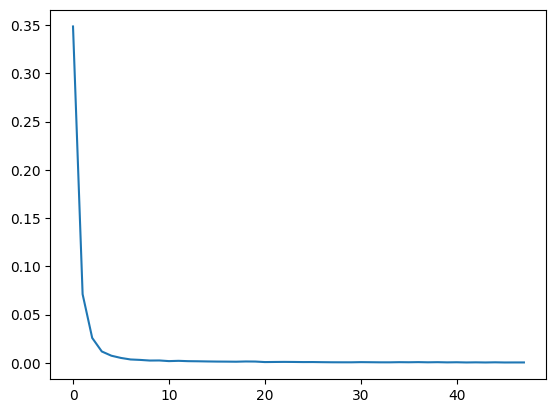

In [20]:
# plot losses
plt.plot(clf.history['loss'])

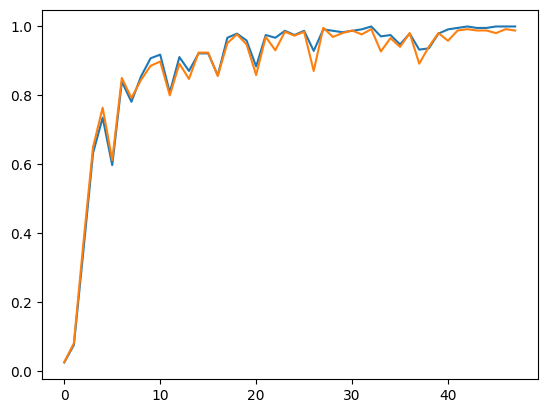

In [21]:
# plot auc
plt.plot(clf.history['train_f1'])
plt.plot(clf.history['valid_f1'])

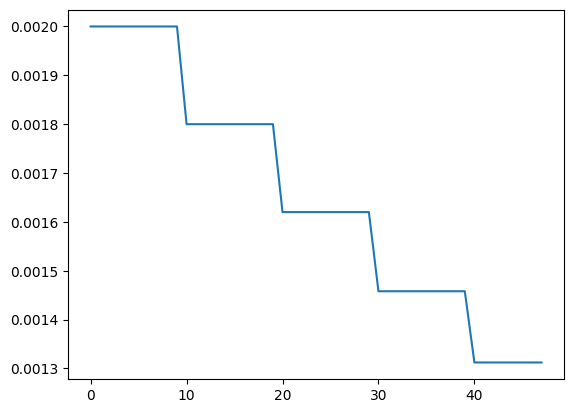

In [22]:
# plot learning rates
plt.plot(clf.history['lr'])

# Predictions

In [23]:
# preds = clf.predict_proba(X_test)
preds = clf.predict(X_test)
test_f1 = f1_score(preds, y_test)

preds_val = clf.predict(X_val)
valid_f1 = f1_score(preds_val, y_val)

print("BEST VALID SCORE : ", clf.best_cost)
print("FINAL TEST SCORE : ", test_f1)

BEST VALID SCORE :  0.9961089494163424
FINAL TEST SCORE :  0.9899396378269618


In [24]:
# check that best weights are used
assert np.isclose(valid_f1, np.max(clf.history['valid_f1']), atol=1e-6)

# Save and load Model

In [25]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [26]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [27]:
# loaded_preds = loaded_clf.predict_proba(X_test)
loaded_preds = loaded_clf.predict(X_test)
loaded_test_f1 = f1_score(loaded_preds, y_test)

print("FINAL TEST SCORE : ",loaded_test_f1)

FINAL TEST SCORE :  0.9899396378269618


- FINAL TEST SCORE : 0.9979633401221996
- momentum = 0.9 : 0.9899396378269618

In [28]:
assert(test_f1 == loaded_test_f1)

# Global explainability : feat importance summing to 

In [29]:
clf.feature_importances_

array([9.29075774e-05, 2.98793918e-01, 3.44703564e-05, 1.40206916e-01,
       9.76540279e-05, 1.01136989e-03, 3.24445748e-07, 3.19661553e-06,
       8.58847869e-05, 9.10427161e-06, 1.14633792e-05, 2.14695513e-05,
       2.12286555e-04, 1.01511684e-05, 1.15567940e-05, 8.60690959e-06,
       9.90713125e-05, 1.69540511e-01, 4.89235597e-07, 1.14573767e-04,
       2.20977180e-04, 7.16285534e-03, 1.94777096e-05, 2.04015478e-05,
       3.36601909e-05, 2.29963810e-05, 9.98511148e-06, 4.06353689e-04,
       3.06215821e-04, 3.80849884e-01, 5.81267540e-04])

# Local explainability and masks

In [30]:
explain_matrix, masks = clf.explain(X_test)

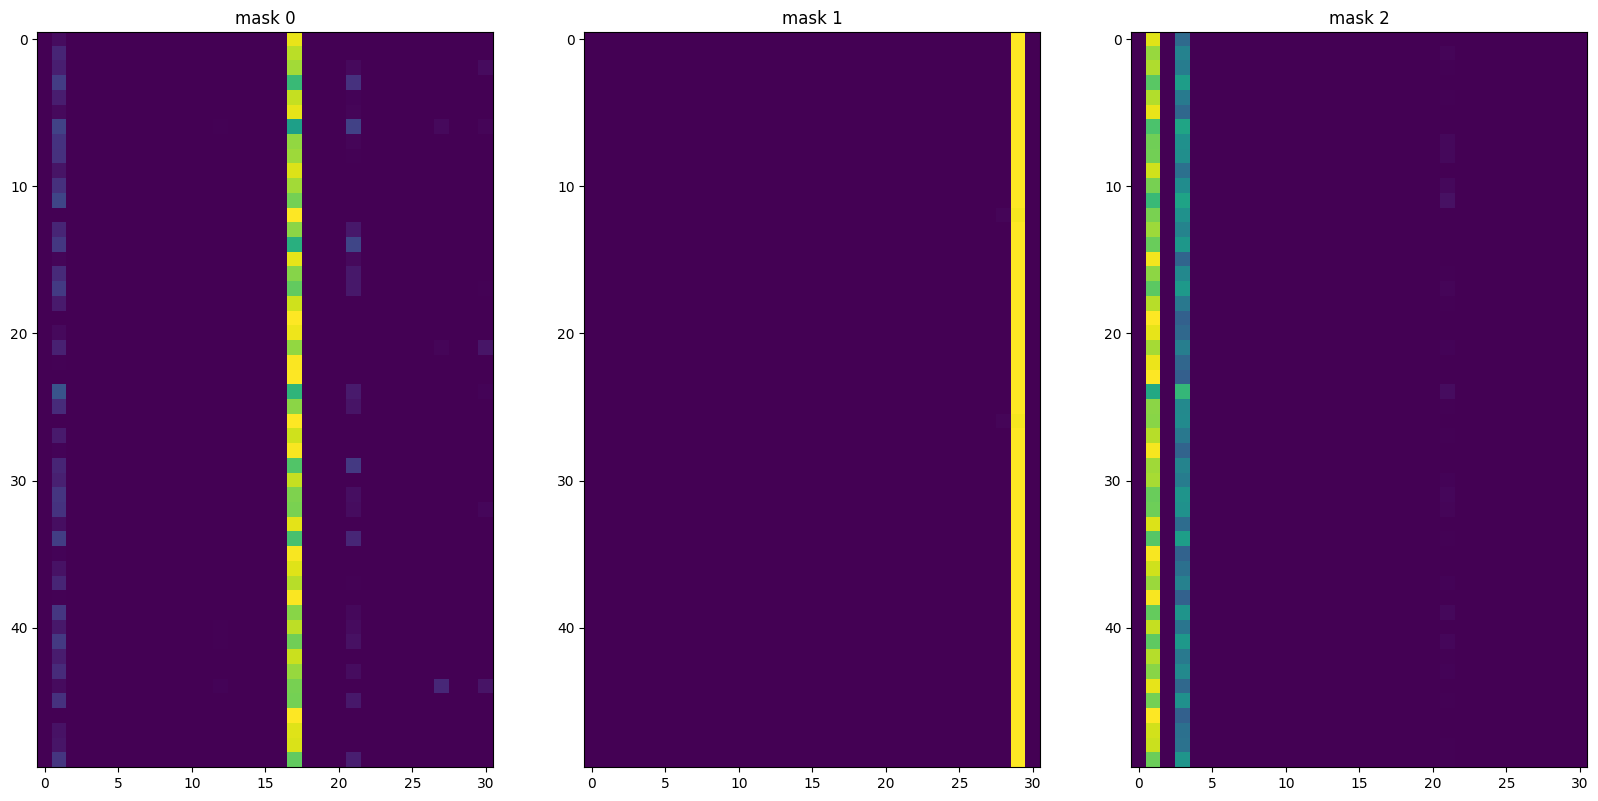

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# AutoKeras

In [ ]:
import autokeras as ak